In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/research_work/extracted_dataset_1fps/dataset_1fps_output

/content/drive/MyDrive/research_work/extracted_dataset_1fps/dataset_1fps_output


In [ ]:
import os, sys

# Open a file
path = "/content/drive/MyDrive/research_work/extracted_dataset_1fps/dataset_1fps_output"
dirs = os.listdir( path )

# This would print all the files and directories
for file in dirs:
   print(file)

train
.ipynb_checkpoints
test


In [ ]:
import os, sys

# Open a file
path = "/content/drive/MyDrive/research_work/extracted_dataset_1fps/dataset_1fps_output/train/Not Hungry"
print(len(os.listdir( path )))

369


In [ ]:
import random
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import json
import albumentations as A
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from tqdm import tqdm_notebook
from torch.utils.data import DataLoader

In [ ]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 7.6 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

In [ ]:
# Define Transforms
# Using Albumentations for image augmentation
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
train_data_path = '/content/drive/MyDrive/research_work/extracted_dataset_1fps/dataset_1fps_output/train'
test_data_path = '/content/drive/MyDrive/research_work/extracted_dataset_1fps/dataset_1fps_output/test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values


# get all the paths from train_data_path and append image paths and class to to respective lists
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])


# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]


# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  /content/drive/MyDrive/research_work/extracted_dataset_1fps/dataset_1fps_output/train/Not Hungry/scene18001 (2).jpg
class example:  Not Hungry
Train size: 679
Valid size: 170
Test size: 214


In [ ]:
# Create dictionary for class indexes


idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
print(class_to_idx)

{'Not Hungry': 0, 'Hungry': 1}


In [ ]:
from torch.utils.data import Dataset

In [ ]:
class FishDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label


#Create Dataset
train_dataset = FishDataset(train_image_paths,train_transforms)
valid_dataset = FishDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = FishDataset(test_image_paths,test_transforms)

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 256, 256])
The label for 50th image in train dataset:  0


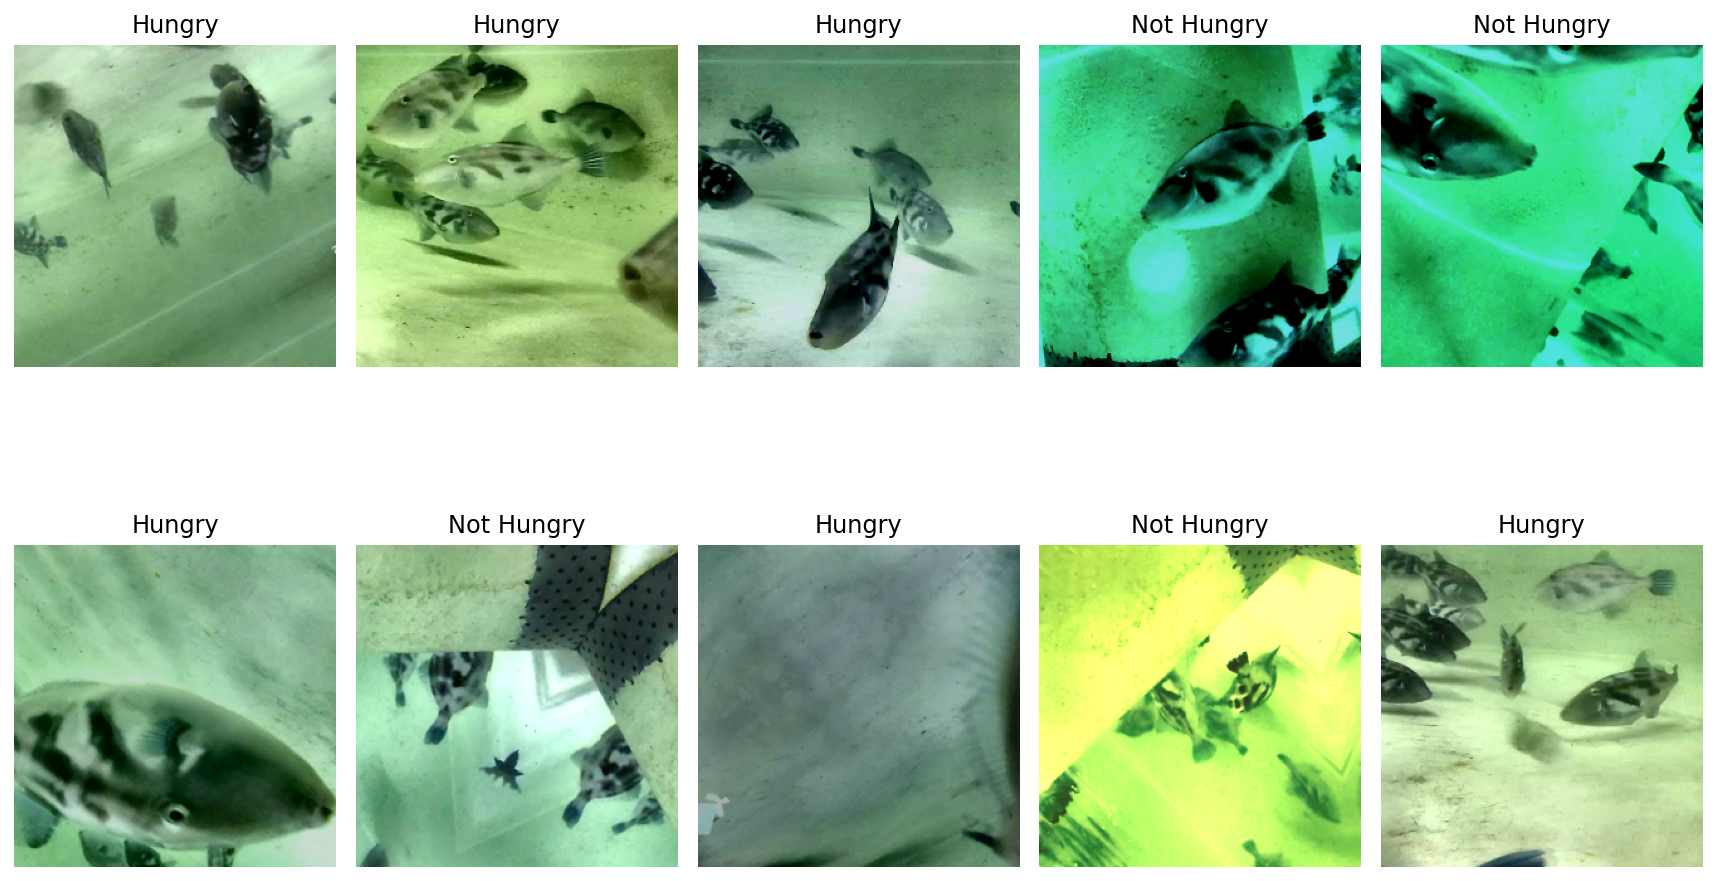

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


# Visualize Dataset
# Images are plotted after augmentation


def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):

    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols


    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:

# Define Dataloaders


train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=1, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

In [ ]:
resnet34 = models.resnet34()

In [ ]:
class ResnetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = nn.Sequential(*model.children())[:-1]
    def forward(self, x):
        return self.model(x)

In [ ]:
feature_extractor = ResnetFeatureExtractor(resnet34)
feature_extractor

ResnetFeatureExtractor(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin